In [1]:
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import jax.numpy as jnp
import optax
import jax
import numpy as np
from stochastic_interpolant.neural_network import NeuralNetwork
from stochastic_interpolant.dataloaders import (
    DatasetSampler,GaussianReferenceSampler,
    IndependenceCouplingSampler,build_trainloader,testloader_factory)
from stochastic_interpolant.loss_functions import get_trig_interpolants,root_prod_gamma,root_prod_gammadot,get_loss_functions
from stochastic_interpolant.data_generators import inf_train_gen
from stochastic_interpolant.model_training import train_model

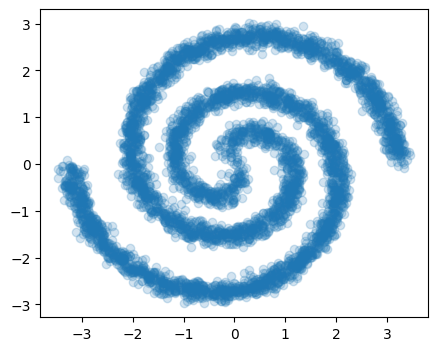

In [2]:
num_target = 5000
target_samples = inf_train_gen('2spirals',rng = 50,batch_size = num_target)
plt.figure(figsize=(5,4))
plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.2)
plt.show()

In [3]:
I,It = get_trig_interpolants()
gamma = root_prod_gamma
gammadot = root_prod_gammadot
loss_b,loss_denoise = get_loss_functions(I,It,gamma,gammadot)

b_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(21239)
)
eta_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(30238)
)

data_coupling_sampler = IndependenceCouplingSampler(
    GaussianReferenceSampler((2,)),
    DatasetSampler(target_samples)
    )
batch_size = 1024

train_loader = build_trainloader(batch_size,jax.random.PRNGKey(124),data_coupling_sampler)
test_factory = testloader_factory(batch_size,jax.random.PRNGKey(32498130),data_coupling_sampler)

In [4]:
b_optim = optax.nadamw(4e-4)

b_model,b_loss_history = train_model(
  model = b_model,
  optim = b_optim,
  steps = 100000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_b,
  print_every = 5000,
  num_testloader_batches = 100,
)


  0%|          | 0/100000 [00:00<?, ?it/s]

step=0 | train_loss=-0.0056206677 | test_loss= -0.45696762
step=5000 | train_loss=-1.7398053 | test_loss= -1.7565433
step=10000 | train_loss=-1.7499671 | test_loss= -1.9136103
step=15000 | train_loss=-1.4781392 | test_loss= -2.0533674
step=20000 | train_loss=-2.6427858 | test_loss= -2.122457
step=25000 | train_loss=-2.342432 | test_loss= -2.178884
step=30000 | train_loss=-2.113813 | test_loss= -2.217226
step=35000 | train_loss=-3.104047 | test_loss= -2.2845497
step=40000 | train_loss=-1.572489 | test_loss= -2.3117762
step=45000 | train_loss=-1.9345775 | test_loss= -2.329456
step=50000 | train_loss=-2.4223905 | test_loss= -2.3283782
step=55000 | train_loss=-2.8884943 | test_loss= -2.312858
step=60000 | train_loss=-2.1426475 | test_loss= -2.3545797
step=65000 | train_loss=-1.9585376 | test_loss= -2.3725247
step=70000 | train_loss=-1.7720895 | test_loss= -2.4207544
step=75000 | train_loss=-2.315662 | test_loss= -2.3802464
step=80000 | train_loss=-2.2359865 | test_loss= -2.4169352
step=850

In [5]:
eta_optim = optax.nadamw(4e-4)

eta_model,eta_loss_history = train_model(
  model = eta_model,
  optim = eta_optim,
  steps = 30000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_denoise,
  print_every = 5000,
  num_testloader_batches = 100,
)

  0%|          | 0/30000 [00:00<?, ?it/s]

step=0 | train_loss=0.13146152 | test_loss= -0.21887538
step=5000 | train_loss=-0.36971658 | test_loss= -0.37174338
step=10000 | train_loss=-0.3766927 | test_loss= -0.3785311
step=15000 | train_loss=-0.43212736 | test_loss= -0.3805773
step=20000 | train_loss=-0.43622047 | test_loss= -0.3824628
step=25000 | train_loss=-0.4064361 | test_loss= -0.38366625
step=29999 | train_loss=-0.35885096 | test_loss= -0.38326743


In [6]:
from stochastic_interpolant.sampler import StochasticSampler

stochastic_sampler = StochasticSampler(gamma,b_model,eta_model)
X0 = jax.random.normal(jax.random.PRNGKey(13334),(10000,2))

X,sol = stochastic_sampler.sample_trajectory(X0,eps = 0.)

2024-05-16 17:30:57.020775: W external/xla/xla/service/hlo_rematerialization.cc:2946] Can't reduce memory use below 16.93GiB (18177979592 bytes) by rematerialization; only reduced to 17.88GiB (19200480472 bytes), down from 17.88GiB (19200480472 bytes) originally


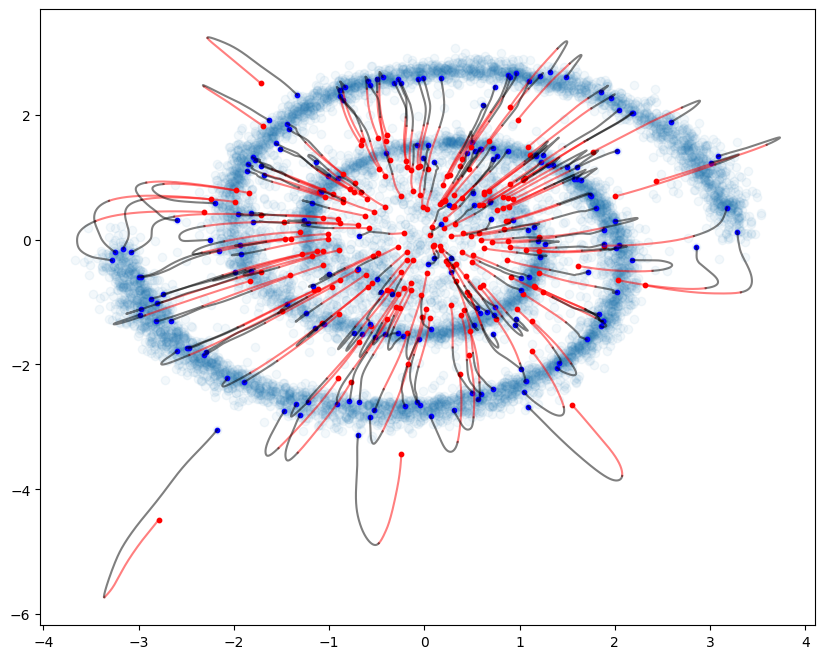

: 

In [11]:
num_trajectories = 200

time_points = np.linspace(0,0.5,500)
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.05)

path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c = 'red',alpha = 0.5)

time_points = np.linspace(0.5,1.,500)
path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c='black',alpha = 0.5)

plt.scatter(X0[:num_trajectories,0],X0[:num_trajectories,1],c = 'red',s = 10.)

plt.scatter(X[:num_trajectories,0],X[:num_trajectories,1],c = 'blue',s = 10.)
plt.show()

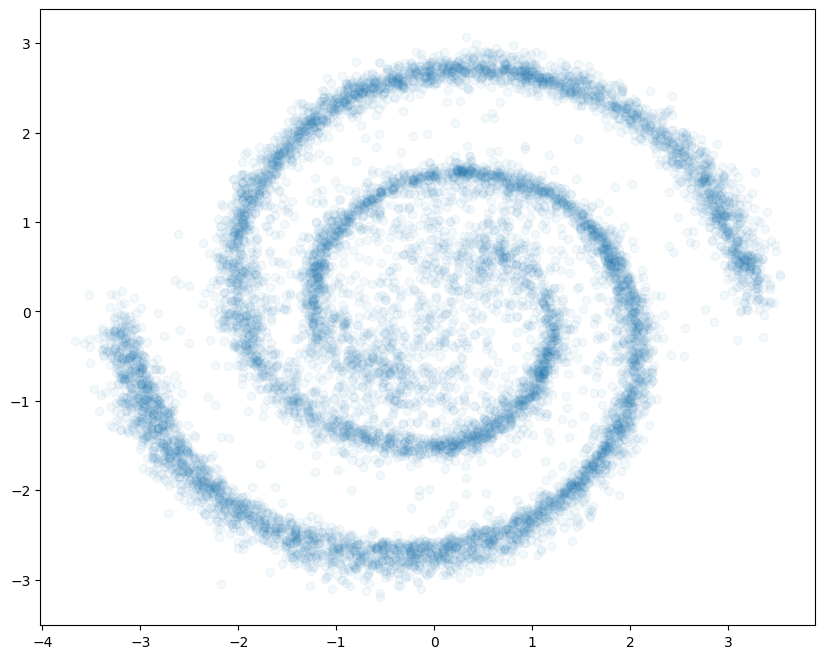

In [8]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.05)


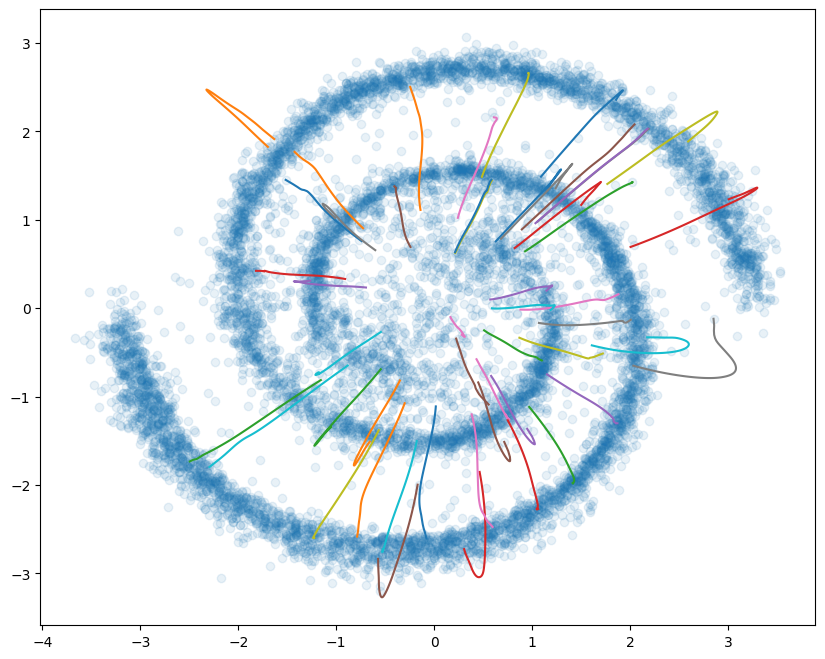

In [9]:
time_points = np.linspace(0,1,100)

path = jnp.array([sol.evaluate(t)[:50] for t in time_points])
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.1)
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1])

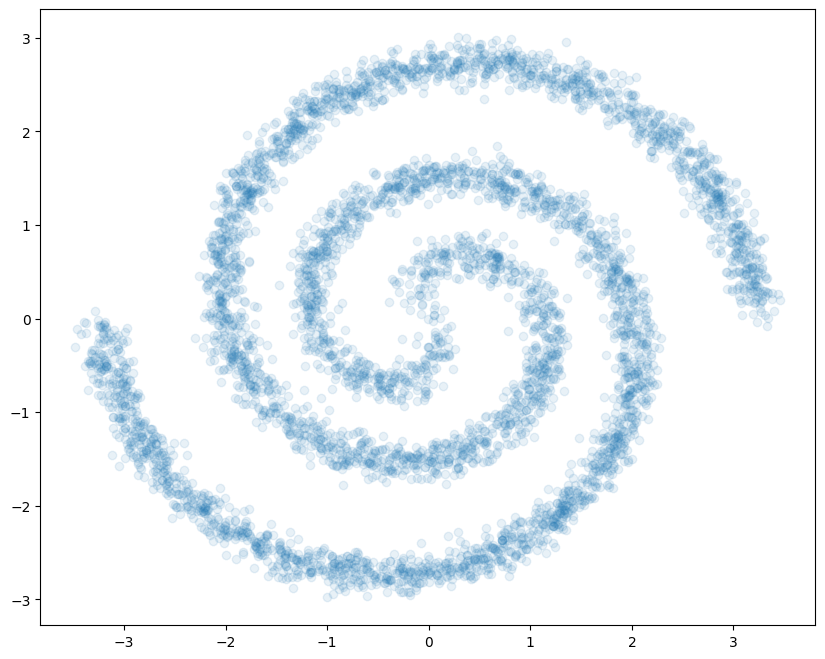

In [10]:
plt.figure(figsize=(10,8))
plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.1)
